# 並列処理とループの例

In [1]:

from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, END
from operator import add

# --- 状態の定義 ---
class State(TypedDict):
    query: str
    results: Annotated[List[str], add]  # 並列処理で安全にリストを結合
    attempts: int

# --- ノード関数 ---
def fetch_a(state: State) -> State:
    print("データA取得中")
    return {"results": ["結果A"]}  # 新しいリストを返す

def fetch_b(state: State) -> State:
    print("データB取得中")
    return {"results": ["結果B"]}  # 新しいリストを返す

def check_results(state: State) -> State:
    print("結果を確認中...")
    state["attempts"] += 1
    # 2回目のチェックで終了
    if state["attempts"] < 2:
        print("結果が不十分です。再試行します...")
        return state  # → ループ
    print("十分な結果が得られました。処理を完了します。")
    return state

# --- グラフ構築 ---
graph = StateGraph(State)

# 開始ノードを追加
def start_parallel(state: State) -> State:
    print("並列処理を開始します")
    return state

graph.add_node("start", start_parallel)
graph.add_node("fetch_a", fetch_a)
graph.add_node("fetch_b", fetch_b)
graph.add_node("check", check_results)

# エントリーポイントを設定
graph.set_entry_point("start")

# startから並列でfetch_aとfetch_bを実行
graph.add_edge("start", "fetch_a")
graph.add_edge("start", "fetch_b")

# fetch_a と fetch_b の両方からcheckへ
graph.add_edge("fetch_a", "check")
graph.add_edge("fetch_b", "check")

# check の結果次第でループまたは終了
graph.add_conditional_edges(
    "check",
    lambda state: "retry" if state["attempts"] < 2 else "done",
    {"retry": "start", "done": END},  # startに戻して再度並列実行
)

app = graph.compile()

# --- 実行例 ---
print("=== 実行 ===")

app.invoke({"query": "情報検索", "results": [], "attempts": 0})

=== 実行 ===
並列処理を開始します
データA取得中
データB取得中
結果を確認中...
結果が不十分です。再試行します...
並列処理を開始します
データA取得中
データB取得中
結果を確認中...
十分な結果が得られました。処理を完了します。


{'query': '情報検索',
 'results': ['結果A',
  '結果B',
  '結果A',
  '結果B',
  '結果A',
  '結果B',
  '結果A',
  '結果B',
  '結果A',
  '結果B',
  '結果A',
  '結果B',
  '結果A',
  '結果B',
  '結果A',
  '結果B',
  '結果A',
  '結果B',
  '結果A',
  '結果B'],
 'attempts': 2}

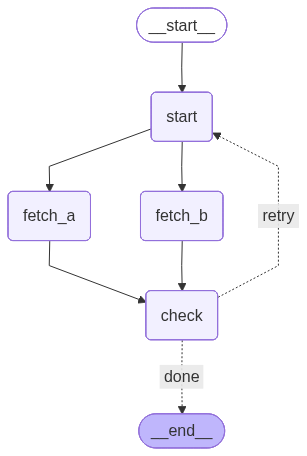

In [ ]:
from IPython.display import Image
# コンパイル済みグラフから図を生成して表示
Image(app.get_graph().draw_mermaid_png())